In [2]:
!pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import ultralytics
from ultralytics import YOLO
model = YOLO('yolov8l.pt')

100%|██████████| 83.7M/83.7M [00:00<00:00, 123MB/s]


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [5]:
!kaggle datasets download -d adarshsng/heart-mri-image-dataset-left-atrial-segmentation

 98% 449M/459M [00:08<00:00, 63.1MB/s]
100% 459M/459M [00:08<00:00, 58.6MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/heart-mri-image-dataset-left-atrial-segmentation.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import subprocess
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

In [3]:
LEARING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

# Download the data.
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q


fatal: destination path 'medical-ai' already exists and is not an empty directory.


In [4]:
finding = "Cardiomegaly"
df = pd.read_csv("./labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [5]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)
print("Number of positive cases: {}".format(n))

Number of positive cases: 146


In [6]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
TRAIN_N = int(n * TRAIN_RATIO)
TEST_N = int(n * TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [7]:
train_labels = pd.concat([positives.iloc[:TRAIN_N], negatives.iloc[:TRAIN_N]])
test_labels = pd.concat([positives.iloc[TRAIN_N:n], negatives.iloc[TRAIN_N:n]])

In [8]:
root_dir = "./images/"
os.makedirs(root_dir + finding + "/test/positive", exist_ok=True)
os.makedirs(root_dir + finding + "/test/negative", exist_ok=True)
os.makedirs(root_dir + finding + "/train/positive", exist_ok=True)
os.makedirs(root_dir + finding + "/train/negative", exist_ok=True)

In [9]:
for idx, image in positives[:TRAIN_N].iterrows():
    source = root_dir + image["filename"]
    dst = root_dir + finding + "/train/positive/" + image["filename"]
    shutil.copyfile(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
    source = root_dir + image["filename"]
    dst = root_dir + finding + "/test/positive/" + image["filename"]
    shutil.copyfile(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
    source = root_dir + image["filename"]
    dst = root_dir + finding + "/train/negative/" + image["filename"]
    shutil.copyfile(source, dst)

for idx, image in negatives[TRAIN_N:].iterrows():
    source = root_dir + image["filename"]
    dst = root_dir + finding + "/test/negative/" + image["filename"]
    shutil.copyfile(source, dst)

In [10]:
positive_imgs, negative_imgs = [], []
def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

for idx, row in positives[:6].iterrows():
    image_path = root_dir + row["filename"]
    image = Image.open(image_path).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
    positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
    image_path = root_dir + row["filename"]
    image = Image.open(image_path).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
    negative_imgs.append(load_image_into_numpy_array(image))

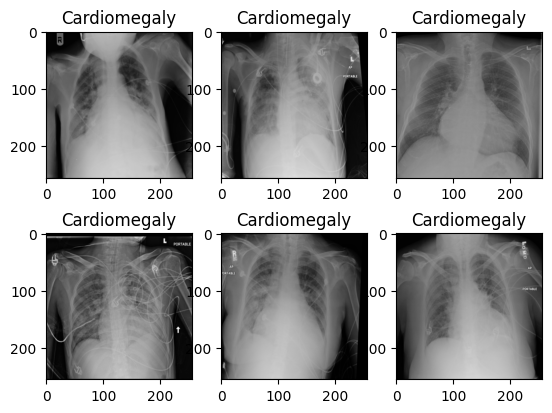

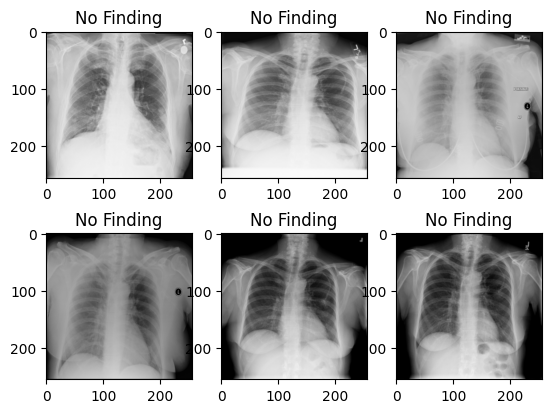

In [11]:
for idx, img in enumerate(positive_imgs):
    plt.subplot(2,3,idx+1)
    plt.title(finding)
    plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs):
    plt.subplot(2,3,idx+1)
    plt.title("No Finding")
    plt.imshow(negative_imgs[idx])
plt.show()

In [12]:
pre_trained_model = InceptionV3(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [13]:
base_dir = './images/'
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=1,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=1,
    class_mode='binary'
)

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2

Found 232 images belonging to 2 classes.
Found 894 images belonging to 2 classes.


In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=5,
    validation_data=test_generator,
    validation_steps=test_steps,
    verbose=2
)

Epoch 1/5


KeyboardInterrupt: 

In [19]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=1,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=1,
    class_mode='binary'
)

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2

Found 232 images belonging to 2 classes.
Found 894 images belonging to 2 classes.


In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_steps,
    verbose=2
)

Epoch 1/20


KeyboardInterrupt: 

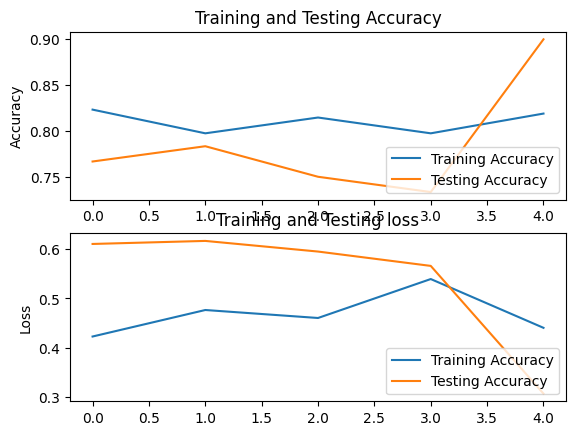

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Testing Accuracy')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(epochs, loss, label='Training Accuracy')
plt.plot(epochs, val_loss, label='Testing Accuracy')
plt.ylabel('Loss')
plt.title('Training and Testing loss')
plt.legend(loc='lower right')

In [22]:
def predict_image(filename):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    score = predictions[0]
    return score

def show_df_row(row):
    filename = "images/" + row['filename']
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), color_mode='rgb')
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    pred = model.predict(img_array)[0][0]
    guess = "neg"
    if pred > 0.5:
        guess = "pos"
    print(f"filename: {filename}")
    print(f"actual: {row['label']}")
    print(f"predicted: {guess} ({pred})")
    plt.imshow(img)
    plt.show()


In [23]:
results = []
for image in os.listdir(test_neg_dir):
    filename = test_neg_dir + "/" + image
    confidence = predict_image(filename)
    guess = "pos" if confidence > 0.5 else "neg"
    results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
    filename = test_pos_dir + "/" + image
    confidence = predict_image(filename)
    guess = "pos" if confidence > 0.5 else "neg"
    results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath", "filename", "label", "guess", "confidence"])

1/1 [==============================] - 0s 196ms/step


In [24]:
df.head()

,filepath,filename,label,guess,confidence
0,./images/Cardiomegaly/test/negative/00000193_0...,00000193_001.jpg,neg,neg,[0.0003032173]
1,./images/Cardiomegaly/test/negative/00000402_0...,00000402_008.jpg,neg,neg,[5.151223e-12]
2,./images/Cardiomegaly/test/negative/00000231_0...,00000231_007.jpg,neg,neg,[3.4783254e-16]
3,./images/Cardiomegaly/test/negative/00000440_0...,00000440_000.jpg,neg,neg,[8.355691e-17]
4,./images/Cardiomegaly/test/negative/00000194_0...,00000194_004.jpg,neg,neg,[2.5166742e-17]


1/1 [==============================] - 0s 189ms/step
filename: images/00000121_009.jpg
actual: neg
predicted: neg (1.0344076977983648e-37)


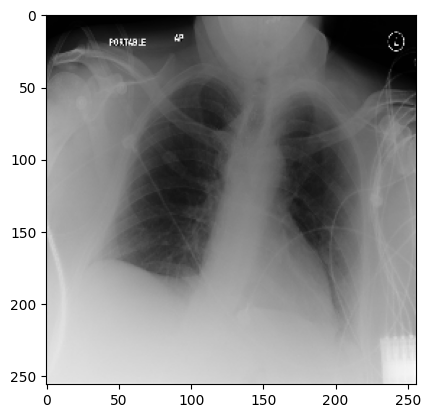

In [47]:
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])
# import os

# filename = "images/00029906_000.jpg"
# if os.path.exists(filename):
#     print("File exists")
# else:
#     print("File does not exist")